## This Section fetches all dependencies need for this project to function correctly


In [ ]:
!pip install numpy
!pip install opencv-python
!pip install pycryptodome
!pip install tinyec


     |████████████████████████████████| 2.0 MB 28.8 MB/s 
  Created wheel for tinyec: filename=tinyec-0.4.0-py3-none-any.whl size=20892 sha256=7bb5c7ab71adc5afe0464ed9634aa9c49d609a197d81b9571141ecb1ef5d438b
  Stored in directory: /root/.cache/pip/wheels/8e/5c/09/6730b2b261b8329cf6c339003a415b98ae1cdd1552d5882fcf
Successfully built tinyec


## Bit Plane Slicing Testing 




In [ ]:
#imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
import random
import sys

In [ ]:
#mathematics behind this function 
class SeedRandom():
    def __init__(self,seed):
        random.seed(seed)
    def rand(self):
        return int(random.random()*(10 ** 16)) #function to generate key
# seed_obj = SeedRandom(90)
# for i in range(100):
#   print(seed_obj.rand(8))

512 512
512 512


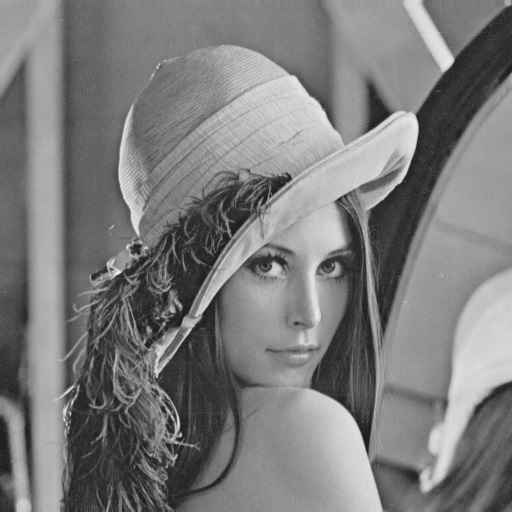

In [ ]:
#importing the Image and Displaying
img = cv2.imread(r'/content/lena.jpg',0) #input image
print(img.shape[0],img.shape[1])
final_x = img.shape[0]
final_y = img.shape[1]
print(final_x,final_y)
#display image
cv2_imshow(img)

In [ ]:
#Functions that will be used for bit plane slicing 
# ---> Transposition of bits Pixel wise (circular right shift)
# ---> Row wise right shift
list_seeds = []
def cov_binary(num):
    binary_num = [int(i) for i in list('{0:0b}'.format(num))]
    for j in range(8 - len(binary_num)):
        binary_num.insert(0,0)        
    return binary_num
def conv_decimal(listt):
    x = 0
    for i in range(8):
        x = x + int(listt[i])*(2**(7-i))
    return x
def discriminate_bit(bit,img):
    seed = int(random.random()*9223372036854775807) #random key 
    list_seeds.append(seed)
    seed_obj = SeedRandom(seed) #seed number passed (key is passed to the seed function)
    height_row = img.shape[0]
    width_col = img.shape[1]
    list_seq = [] #list stores the sequence
    for i in range(height_row*width_col):
      list_seq.append(seed_obj.rand()) #constantly generate the random number in sequence -- 250000                           
    z = np.zeros([height_row,width_col])
    final_image = np.zeros([height_row,width_col])
    temp = 0
    for i in range(height_row):
        for j in range(width_col):
            x = cov_binary(img[i][j])
            for k in range(8):                                      
                if k == bit: 
                    #performing right shit
                    shift = (list_seq[temp]%8) + k                      
                    if shift > 7:
                      shift = shift - 8
                    #value = x[k] #storing the value for shift
                    x[k] = x[k]
                    temp = temp+1
                else:
                    x[k] = 0                       
            #x[shift] = value
            x1 = conv_decimal(x)
            z[i][j] = x1
    temp = 0
    for i in range(height_row):
      for j in range(width_col):
        new_col = j+(list_seq[temp]%final_y)
        if new_col >= width_col:
          new_col = new_col - (width_col)
        #print(new_col)
        final_image[i][new_col] = z[i][j]
      temp = temp + 1
    return final_image

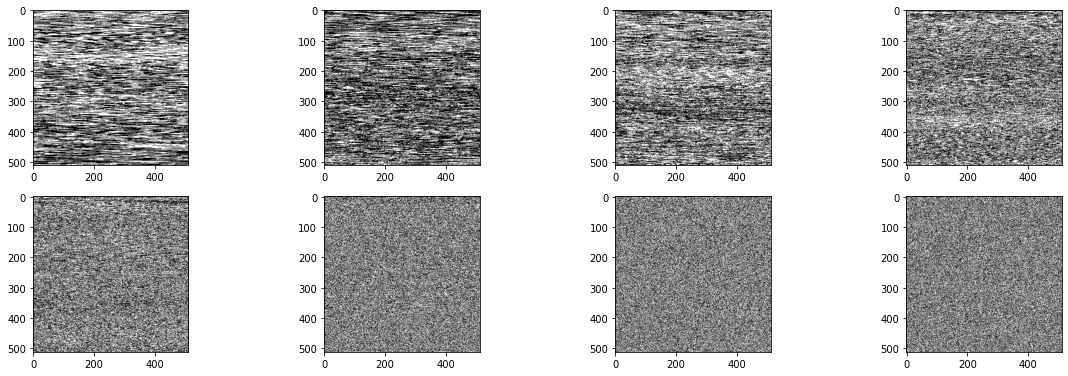

In [ ]:
# set up side-by-side image display
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
encrypted_images_list = []
for i in range(1,9):
    fig.add_subplot(6,4,i)
    display_image = discriminate_bit(i-1,img)
    encrypted_images_list.append(display_image) #saving the encrypted images
    path = r"/content/"+str(i)+"_encrypted.jpg"
    cv2.imwrite(path,display_image)
    plt.imshow(display_image, cmap='gray')

#plt.show(block=True)

#ECC + AES hybrid

In [ ]:
#functions to be used in ECC+AES
def encrypt_AES_GCM(msg, secretKey):
    aesCipher = AES.new(secretKey, AES.MODE_GCM)
    ciphertext, authTag = aesCipher.encrypt_and_digest(msg)
    return (ciphertext, aesCipher.nonce, authTag)

def decrypt_AES_GCM(ciphertext, nonce, authTag, secretKey):
    aesCipher = AES.new(secretKey, AES.MODE_GCM, nonce)
    plaintext = aesCipher.decrypt_and_verify(ciphertext, authTag)
    return plaintext

def ecc_point_to_256_bit_key(point):
    sha = hashlib.sha256(int.to_bytes(point.x, 32, 'big'))
    sha.update(int.to_bytes(point.y, 32, 'big'))
    return sha.digest()

def encrypt_ECC(msg, pubKey):
    ciphertextPrivKey = secrets.randbelow(curve.field.n)
    sharedECCKey = ciphertextPrivKey * pubKey
    secretKey = ecc_point_to_256_bit_key(sharedECCKey)
    ciphertext, nonce, authTag = encrypt_AES_GCM(msg, secretKey)
    ciphertextPubKey = ciphertextPrivKey * curve.g
    return (ciphertext, nonce, authTag, ciphertextPubKey)

def decrypt_ECC(encryptedMsg, privKey):
    (ciphertext, nonce, authTag, ciphertextPubKey) = encryptedMsg
    sharedECCKey = privKey * ciphertextPubKey
    secretKey = ecc_point_to_256_bit_key(sharedECCKey)
    plaintext = decrypt_AES_GCM(ciphertext, nonce, authTag, secretKey)
    return plaintext    

In [ ]:
# tinyec library to generate a ECC private-public key
from tinyec import registry 
from Crypto.Cipher import AES
import hashlib, secrets, binascii

curve = registry.get_curve('brainpoolP256r1')#curve we have chosen
message = ""
for i in list_seeds:
  message = message+str(i)
  message = message+" "
msg = b'Text to be encrypted by ECC public key and '\
      b'decrypted by its corresponding ECC private key' #messsage which needs to be worked upon
res = bytes(message,'utf-8') #converted it to bytes 
msg = res
print("original msg:", msg) 
privKey = secrets.randbelow(curve.field.n)
pubKey = privKey * curve.g

encryptedMsg = encrypt_ECC(msg, pubKey)
encryptedMsgObj = {
    'ciphertext': binascii.hexlify(encryptedMsg[0]),
    'nonce': binascii.hexlify(encryptedMsg[1]),
    'authTag': binascii.hexlify(encryptedMsg[2]),
    'ciphertextPubKey': hex(encryptedMsg[3].x) + hex(encryptedMsg[3].y % 2)[2:]
}
print("encrypted msg:", encryptedMsgObj)



original msg: b'1356678995914433536 8342241603964457984 536986403153760256 1678640980823813120 3840258626043198464 237225104444238848 8996974888441794560 8267682765869317120 '
encrypted msg: {'ciphertext': b'bd488486e779a7294d8ba05ab8c41e0975c95c8e27868677274591b742b2e65d9d0a65dc2db71fcd92f6ce6413ddc2d6a30754e4196a34e1538650880d5262aa76152e1910e884d44bfb09be7076e29c31f5a2f09ff10ebb96bb6f4bd8e3bb57e30de0ef3a541b160dc90f073753fdf3b3d48bad72455fee7ab73e21440153ef20ce62f71db7c7969eff04f357b39c69e4eaac45f30dcce437f51add324c', 'nonce': b'a0982e5601086313bba5c05d023e4263', 'authTag': b'c7dcad80156984c61f633c67b9b95ec0', 'ciphertextPubKey': '0x7597d2bd2001a3b1a242c90a388928568e0dced097ea09893a29bef8bea1a80d0'}


## Decryption

In [ ]:
decryptedMsg = decrypt_ECC(encryptedMsg, privKey)
print("decrypted msg:", decryptedMsg)

decrypted msg: b'1356678995914433536 8342241603964457984 536986403153760256 1678640980823813120 3840258626043198464 237225104444238848 8996974888441794560 8267682765869317120 '


## Decryption of the Image

In [ ]:
#convert the byte data to string 
decrypted_str = decryptedMsg.decode('UTF-8')
print("Converting the byte data to string: "+decrypted_str)
#splitting the string to get the keys 
list_decrypted_keys = decrypted_str.split(" ")
list_decrypted_keys.pop()
print(list_decrypted_keys) #this list will contain all the keys

Converting the byte data to string: 1356678995914433536 8342241603964457984 536986403153760256 1678640980823813120 3840258626043198464 237225104444238848 8996974888441794560 8267682765869317120 
['1356678995914433536', '8342241603964457984', '536986403153760256', '1678640980823813120', '3840258626043198464', '237225104444238848', '8996974888441794560', '8267682765869317120']


In [ ]:
print(encrypted_images_list)

[array([[128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [128., 128., 128., ..., 128., 128., 128.],
       [  0.,   0., 128., ...,   0.,   0.,   0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [64., 64., 64., ..., 64., 64., 64.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [32., 32., 32., ...,  0.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 32.,  0.]]), array([[16.,  0.,  0., ...,  0., 16., 16.],
       [16., 16., 16., ..., 16.,  0., 16.],
       [16., 16., 16., ..., 16.,  0.,  0.

In [ ]:
#using the same seed function we will generate the same key sequence and get the original image back
# --> Row wise circular left shift
# --> Transposition of pixles (bitwise) - circular left shift
def decrypt_image_bits(bit,image_number,img,list_decrypted_keys,path):
    seed = int(list_decrypted_keys[image_number])
    print(seed)
    seed_obj = SeedRandom(seed) #seed number passed 
    height_row = img.shape[0]
    width_col = img.shape[1]
    print(height_row,width_col)
    list_seq = [] #list stores the sequence
    for i in range(height_row*width_col):
      list_seq.append(seed_obj.rand())
    final_image = np.zeros([height_row,width_col])
    z = np.zeros([height_row,width_col])
    temp = 0
    for i in range(height_row):
      for j in range(width_col):
        new_col = j+(list_seq[temp]%final_y)
        if new_col >= width_col:
          new_col = new_col - (width_col)
        #print(new_col)
        final_image[i][j] = img[i][new_col]
      temp = temp + 1
    path1 = r"/content/temp.jpg"
    cv2.imwrite(path1,final_image)
    img2 = cv2.imread(path1,0) 

    
    # temp = 0
    # for i in range(height_row):
    #     for j in range(width_col):
    #         x = cov_binary(img2[i][j])
    #         for k in range(8):
    #             if k == bit: 
    #                 #performing right shit
    #                 shift = list_seq[temp] + k
    #                 if shift > 7:
    #                   shift = shift - 8
    #                 value = x[shift] #storing the value for shift
    #                 temp = temp+1

    #                 # x[k] = x[k]
    #                 x[k] = value
    #         x1 = conv_decimal(x)
    #         z[i][j] = x1
    
    return final_image
    # for i in range(height_row):
    #   for j in range(width_col):
    #     new_col = j - (list_seq[temp]*50)
    #     print(new_col)
    #     if new_col < 0:
    #       new_col = width_col + new_col
    #     print(new_col)
    #     #print(new_col)
    #     final_image[i][new_col] = z[i][j]
    #   temp = temp + 1
    # return final_image

1356678995914433536
512 512
8342241603964457984
512 512
536986403153760256
512 512
1678640980823813120
512 512
3840258626043198464
512 512
237225104444238848
512 512
8996974888441794560
512 512
8267682765869317120
512 512


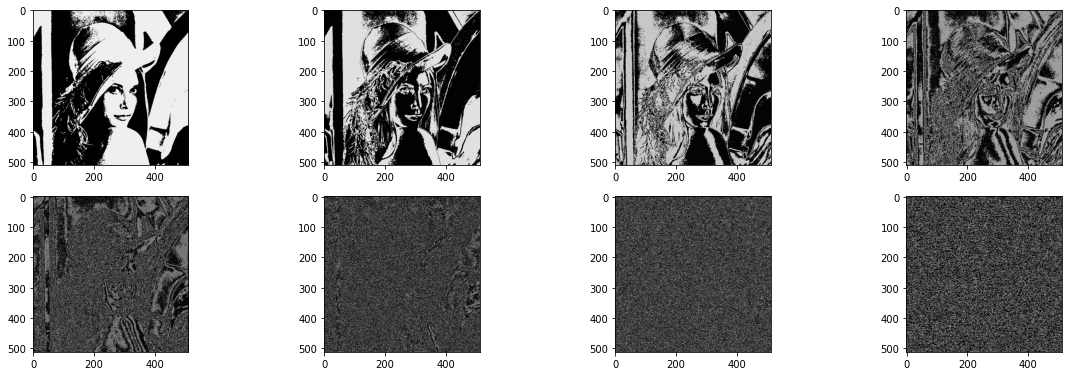

In [ ]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
encrypted_images_list = []
for i in range(1,9):
    fig.add_subplot(6,4,i)
    path = r"/content/"+str(i)+"_encrypted.jpg"
    img = cv2.imread(path,0)
    display_image = decrypt_image_bits(i-1,i-1,img,list_decrypted_keys,path)
    plt.imshow(display_image, cmap='gray')

plt.show(block=True)

1356678995914433536
512 512
8342241603964457984
512 512
536986403153760256
512 512
1678640980823813120
512 512
3840258626043198464
512 512
237225104444238848
512 512
8996974888441794560
512 512
8267682765869317120
512 512


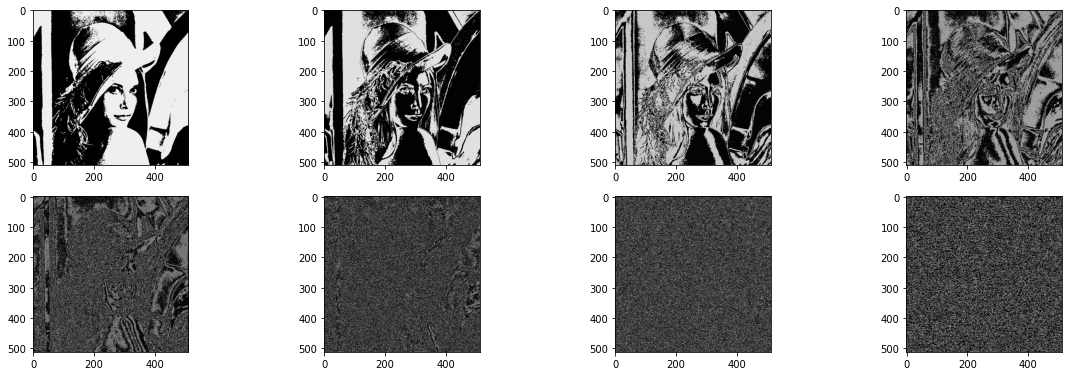

In [ ]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
encrypted_images_list = []
for i in range(1,9):
    fig.add_subplot(6,4,i)
    path = r"/content/"+str(i)+"_encrypted.jpg"
    img = cv2.imread(path,0)
    display_image = decrypt_image_bits(i-1,i-1,img,list_decrypted_keys,path)
    path = r"/content/"+str(i)+"_decrypted.jpg"
    cv2.imwrite(path,display_image)
    plt.imshow(display_image, cmap='gray')

plt.show(block=True)

## Changes TEMP {}

In [ ]:
# def final_output_generation(height_row,width_col):
#   #final_output_image = np.zeros([height_row,width_col])
#   #path_temp = r"/content/temp1.jpg"
#   #cv2.imwrite(path_temp,final_output_image)
#   final_output_image = cv2.imread('/content/1_decrypted.jpg',0)
#   for b in range(2,5):
#     path = r"/content/"+str(b)+"_decrypted.jpg"
#     img = cv2.imread(path,0)
#     print("Merging Image_"+str(b)+"...............")
#     for i in range(height_row):
#         for j in range(width_col):
#             x = cov_binary(img[i][j])
#             for k in range(8):
#                 if k == (b-1): 
#                     value = x[k]
#             x_final = cov_binary(final_output_image[i][j])
#             x_final[b-1] = value
#             x1 = conv_decimal(x_final)
#             final_output_image[i][j] = x1
#   return final_output_image

# display = final_output_generation(final_x,final_y)
# cv2.imwrite("Final_image_output.jpg",display)
# img = cv2.imread(r"/content/Final_image_output.jpg",0)
# print("\n")
# print("Final Image After decryption --> ")
# #cv2_imshow(img)
# # plt.imshow(display, cmap='gray')
# psnr=10*np.log10((255*255)/(1/(225*225)*np.sum(img)*np.sum(img))) #Peak signal to noise Ratio -- whether image is gonna be clear or not
# print('PSNR is: ',psnr)


## Merging all the images to get the Final Output

Merging Image_2...............
Merging Image_3...............
Merging Image_4...............
Merging Image_5...............
Merging Image_6...............
Merging Image_7...............
Merging Image_8...............


Final Image After decryption --> 


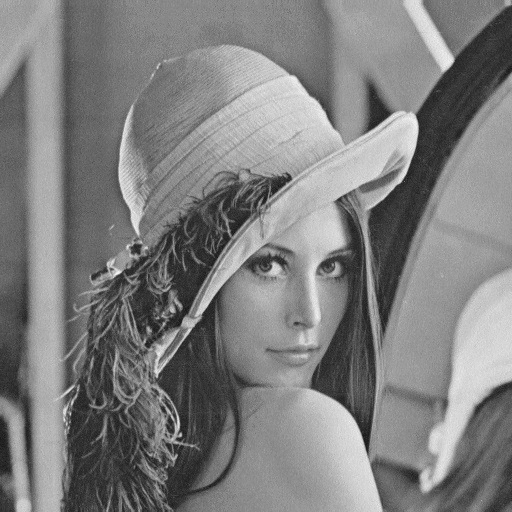

In [ ]:
def final_output_generation(height_row,width_col):
  #final_output_image = np.zeros([height_row,width_col])
  #path_temp = r"/content/temp1.jpg"
  #cv2.imwrite(path_temp,final_output_image)
  final_output_image = cv2.imread('/content/1_decrypted.jpg',0)
  for b in range(2,9):
    path = "/content/"+str(b)+"_decrypted.jpg"
    img = cv2.imread(path,0)
    print("Merging Image_"+str(b)+"...............")
    for i in range(height_row):
        for j in range(width_col):
            final_output_image[i][j] += img[i][j]
  return final_output_image

display = final_output_generation(final_x,final_y)
cv2.imwrite("Final_image_output.jpg",display)
img = cv2.imread(r"/content/Final_image_output.jpg",0)
print("\n")

print("Final Image After decryption --> ")
cv2_imshow(img)
#plt.imshow(display, cmap='gray')


## Image Enhancement


PSNR is:  -77.28536958199437


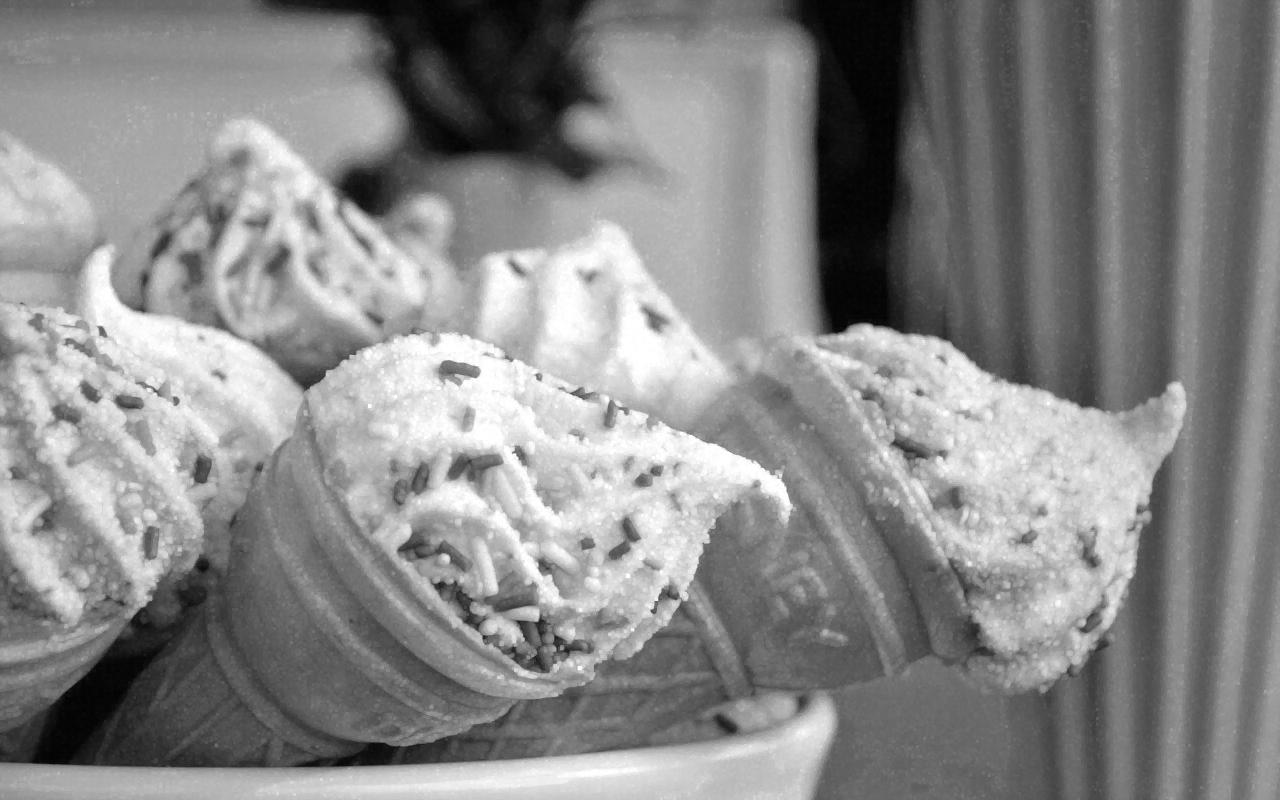

In [ ]:
#----- Python example program for applying a maximum filter to a digital image -----
from PIL import Image
from PIL import ImageFilter

# Method to apply the filter
def applyMaximumFilter(image):
    return image.filter(ImageFilter.MaxFilter);

# Load the image
imagePath   = "/content/Final_image_output.jpg";
imageObject = Image.open(imagePath);

# Apply maximum filter
filterApplied = imageObject;
filterApplied = applyMaximumFilter(filterApplied);

# Display images
imageObject.show();
filterApplied.save("Final.jpg")
imagePath = "/content/Final.jpg"
img = cv2.imread(imagePath)
psnr=10*np.log10((255*255)/(1/(225*225)*np.sum(img)*np.sum(img))) #Peak signal to noise Ratio -- whether image is gonna be clear or not
print('PSNR is: ',psnr)
cv2_imshow(img)

## LZW CODE testing


In [ ]:
from PIL import Image
import os
import numpy as np

class LZW:
    def __init__(self, path):
        self.path = path
        self.compressionDictionary, self.compressionIndex = self.createCompressionDict()
        self.decompressionDictionary, self.decompressionIndex = self.createDecompressionDict()
    
    ''''''
    ''' --------------------- Compression of the Image --------------------- '''
    ''''''

    def compress(self):
        self.initCompress()
        compressedcColors = []
        print("Compressing Image ...")
        compressedcColors.append(self.compressColor(self.red))
        print("Compressing Image ...")
        compressedcColors.append(self.compressColor(self.green))
        print("Compressing Image ...")
        compressedcColors.append(self.compressColor(self.blue))
        print("Image Compressed --------- Writing to File")
        filesplit = str(os.path.basename(self.path)).split('.')
        filename = filesplit[0] + 'Compressed.lzw'
        savingDirectory = os.path.join(os.getcwd(),'CompressedFiles')
        if not os.path.isdir(savingDirectory):
            os.makedirs(savingDirectory)
        with open(os.path.join(savingDirectory,filename),'w') as file:
            for color in compressedcColors:
                for row in color:
                    file.write(row)
                    file.write("\n")
                
    def compressColor(self, colorList):
        compressedColor = []
        i = 0
        for currentRow in colorList:
            currentString = currentRow[0]
            compressedRow = ""
            i+=1
            for charIndex in range(1, len(currentRow)):
                currentChar = currentRow[charIndex]
                if currentString+currentChar in self.compressionDictionary:
                    currentString = currentString+currentChar
                else:
                    compressedRow = compressedRow + str(self.compressionDictionary[currentString]) + ","
                    self.compressionDictionary[currentString+currentChar] = self.compressionIndex
                    self.compressionIndex += 1
                    currentString = currentChar
                currentChar = ""
            compressedRow = compressedRow + str(self.compressionDictionary[currentString])
            compressedColor.append(compressedRow)
        return compressedColor

    ''''''
    ''' --------------------- Deompression of the Image --------------------- '''
    ''''''

    def decompress(self):
        print("Decompressing File ...")
        image = []
        with open(self.path,"r") as file:
            for line in file:
                decodedRow = self.decompressRow(line)
                image.append(np.array(decodedRow))
        image = np.array(image)
        shapeTup = image.shape
        image = image.reshape((3,shapeTup[0]//3,shapeTup[1]))
        self.saveImage(image)
        print("Decompression Done.")  

    def decompressRow(self,line):
        currentRow = line.split(",")
        currentRow[-1] = currentRow[-1][:-1]
        decodedRow = ""
        word,entry = "",""
        decodedRow = decodedRow + self.decompressionDictionary[int(currentRow[0])]
        word = self.decompressionDictionary[int(currentRow[0])]
        for i in range(1,len(currentRow)):
            new = int(currentRow[i])
            if new in self.decompressionDictionary:
                entry = self.decompressionDictionary[new]
                decodedRow += entry
                add = word + entry[0]
                word = entry
            else:
                entry = word + word[0]
                decodedRow += entry
                add = entry
                word = entry
            self.decompressionDictionary[self.decompressionIndex] = add
            self.decompressionIndex+=1
        newRow = decodedRow.split(',')
        decodedRow = [int(x) for x in newRow]
        return decodedRow

    ''''''
    ''' ---------------------- Class Helper Functions ---------------------- '''
    ''''''

    '''
    Used For: Compression of Image
    Function: This function breaks down the image into the three constituting
              image chanels - Red, Green and Blue.
    '''
    def initCompress(self):
        self.image = Image.open(self.path)
        self.height, self.width = self.image.size
        self.red, self.green, self.blue = self.processImage()

    '''
    Used For: Compression of Image
    Function: This function breaks down the image into the three constituting
              image chanels - Red, Green and Blue.
    '''
    def processImage(self):
        image = self.image.convert('RGB')
        red, green, blue = [], [], []
        pixel_values = list(image.getdata())
        iterator = 0
        for height_index in range(self.height):
            R, G, B = "","",""
            for width_index in range(self.width):
                RGB = pixel_values[iterator]
                R = R + str(RGB[0]) + ","
                G = G + str(RGB[1]) + ","
                B = B + str(RGB[2]) + ","
                iterator+=1
            red.append(R[:-1])
            green.append(G[:-1])
            blue.append(B[:-1])
        return red,green,blue


    '''
    Used For: Decompression of Image
    Function: This function will save the decompressed image as <name>.tif
    '''
    def saveImage(self,image):
        print("Saving Decompressed File...")
        filesplit = str(os.path.basename(self.path)).split('Compressed.lzw')
        filename = filesplit[0] + "Decompressed.jpg"
        savingDirectory = os.path.join(os.getcwd(),'DecompressedFiles')
        if not os.path.isdir(savingDirectory):
            os.makedirs(savingDirectory)
        imagelist,imagesize = self.makeImageData(image[0],image[1],image[2])
        imagenew = Image.new('RGB',imagesize)
        imagenew.putdata(imagelist)
        imagenew.save(os.path.join(savingDirectory,filename))

    '''
    Used For: Decompression of Image
    Function: This function will convert and return the image in the (r,g,b) format
              to save the image.
    '''
    def makeImageData(self,r,g,b):
        imagelist = []
        for i in range(len(r)):
            for j in range(len(r[0])):
                imagelist.append((r[i][j],g[i][j],b[i][j]))
        return imagelist,(len(r),len(r[0]))

    '''
    Used For: Compression of Image
    Function: This function will initialise the compression dictionary
    '''
    def createCompressionDict(self):
        dictionary = {}
        for i in range(10):
            dictionary[str(i)] = i
        dictionary[','] = 10
        return dictionary,11

    '''
    Used For: Compression of Image
    Function: This function will initialise the decompression dictionary
    '''
    def createDecompressionDict(self):
        dictionary = {}
        for i in range(10):
            dictionary[i] = str(i)
        dictionary[10] = ','
        return dictionary,11

In [ ]:
compressor = LZW('/content/Final.jpg')
compressor.compress()
decompressor = LZW('/content/CompressedFiles/FinalCompressed.lzw')
decompressor.decompress()

Compressing Image ...
Compressing Image ...
Compressing Image ...
Image Compressed --------- Writing to File
Decompressing File ...
Saving Decompressed File...
Decompression Done.


In [ ]:
img = cv2.imread("/content/DecompressedFiles/FinalDecompressed.jpg")
psnr=10*np.log10((255*255)/(1/(225*225)*np.sum(img)*np.sum(img))) #Peak signal to noise Ratio -- whether image is gonna be clear or not
print('PSNR is: ',psnr)

PSNR is:  -77.28533866662073


## Comparison
### 1. Using Histogram comparison
### 2. PSNR and MSE comparison

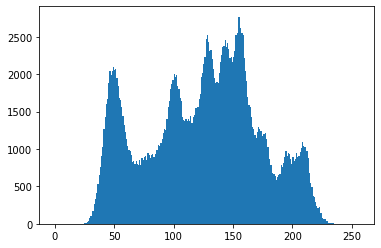

In [ ]:
#plotting the histogram of the original image
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('lena.jpg',0)
  
# alternative way to find histogram of an image
plt.hist(img.ravel(),256,[0,256])
plt.show()

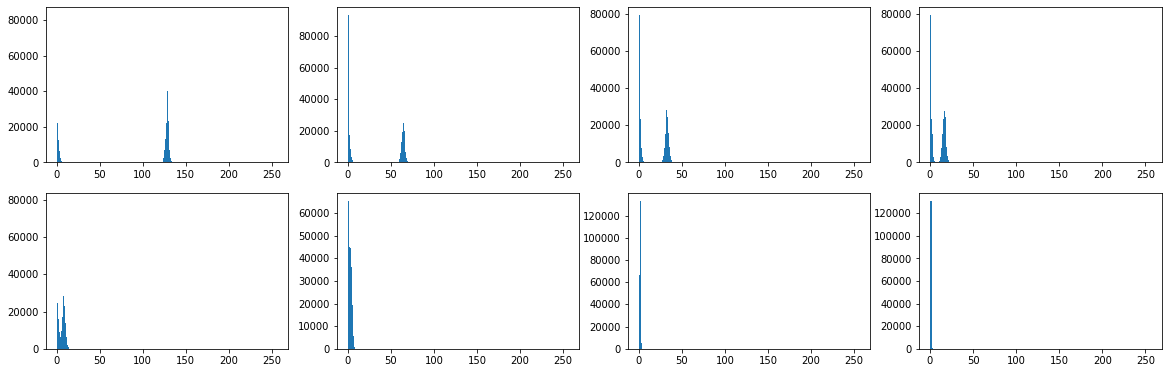

In [ ]:
#plotting the histogram of an encrypted image
# img = cv2.imread('/content/1_encrypted.jpg')
  
# # alternative way to find histogram of an image
# plt.hist(img.ravel(),256,[0,256])
# plt.show()

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(1,9):
  fig.add_subplot(6,4,i)
  path = r"/content/"+str(i)+"_encrypted.jpg"
  img = cv2.imread(path,0)
  plt.hist(img.ravel(),256,[0,256])
plt.show(block = True)
